In [1]:
# importing the dependencies. 
import pandas as pd
import numpy as np
import scipy as sc
from scipy import signal
import matplotlib.pyplot as plt
import h5py
import obspy
from obspy.signal.filter import envelope
from obspy.clients.fdsn import Client
from tqdm import tqdm
from glob import glob
import tsfel
import random
from datetime import timedelta
import calendar
from tsfel import time_series_features_extractor
import warnings
import time
import argparse



import sys
import os

# Get the absolute path of the directory two levels up
two_levels_up = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Append the 'src' directory located two levels up to the system path
sys.path.append(os.path.join(two_levels_up, 'src'))


from utils import apply_cosine_taper
from utils import butterworth_filter
from utils import resample_array

# Ignore all warnings
warnings.filterwarnings("ignore")

# displaying all columns from pandas dataframe
pd.set_option('display.max_columns', None)

In [22]:
start_time = 10
end_time = 40
taper_amount = 10
low = 1
high = 15
original_sr = 100
num_corners = 4
new_sr = 100

comcat_file_name = "/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5"
comcat_csv_file = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
f = h5py.File(comcat_file_name, 'r')

buckets = [comcat_csv_file['trace_name'].values[i].split('$')[0] for i in range(len(comcat_csv_file))]
indices = [int(comcat_csv_file['trace_name'].values[i].split('$')[1].split(',')[0]) for i in range(len(comcat_csv_file))]
p_arrivals = np.array([comcat_csv_file['trace_P_arrival_sample'].values])[0]
source = comcat_csv_file['source_type'].values

buck_exp = np.array(buckets)[np.where(source == 'explosion')[0]]
ind_exp = np.array(indices)[np.where(source == 'explosion')[0]]
p_arrival_exp = p_arrivals[np.where(source == 'explosion')[0]]
data_exp = []
for i in tqdm(range(30)):
     data_exp.append(f['/data/'+buck_exp[i]][ind_exp[i], 2, int(p_arrival_exp[i] - start_time*100): int(p_arrival_exp[i] +end_time*100)])
               
data_exp = np.array(data_exp)




tapered_exp = apply_cosine_taper(data_exp, taper_percent = taper_amount)  
## Mention the bandpass filter frequencies. 
filtered_exp = np.array(butterworth_filter(data_exp, low, high, original_sr, num_corners, 'bandpass'))

exp_Z = filtered_exp         
# Normalizing the data.              
exp_Z = exp_Z/np.max(abs(exp_Z), axis = 1)[:, np.newaxis]

# Resampling the data
exp_Z = np.array([resample_array(arr, original_sr, new_sr) for arr in exp_Z])

100%|██████████| 30/30 [00:00<00:00, 158.47it/s]


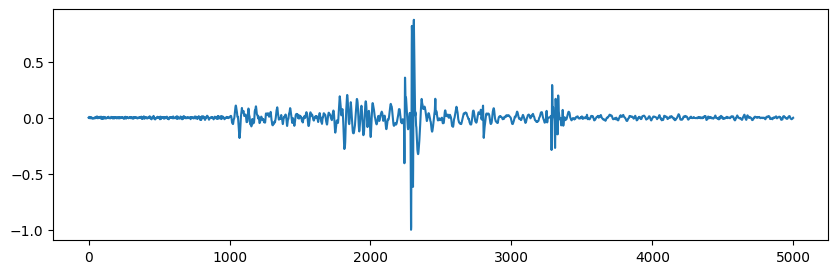

In [23]:
plt.figure(figsize = [10,3])
plt.plot(exp_Z[0])


In [29]:
exp_Z[0:3]

array([[  1.74077906e-04,   1.14760120e-03,   3.45529003e-03, ...,
         -1.52486326e-03,  -6.89028599e-04,  -6.11855357e-05],
       [ -9.95171128e-04,  -6.30593797e-03,  -1.81779140e-02, ...,
          1.48053285e-01,   1.07471279e-01,   6.23694299e-02],
       [  7.84189620e-03,   5.14210103e-02,   1.55449003e-01, ...,
         -6.35130658e-02,  -6.30018922e-02,  -6.29974842e-02]])

In [32]:
data = exp_Z[0:30]
nyquist = 0.5 * 100
low = 0.05 / nyquist
high = 20 / nyquist
b, a = signal.butter(4, [low, high], btype='band')

# Apply the taper+filter to the signal
taper = signal.windows.tukey(data.shape[-1], alpha=0.1)
data = np.array([np.multiply(taper, row) for row in data])
filtered_signal = np.array([signal.filtfilt(b, a, row) for row in data])





5000

In [35]:
# resample
number_of_samples = int(filtered_signal.shape[1] * 1)
data = np.array([signal.resample(row, number_of_samples) for row in filtered_signal])

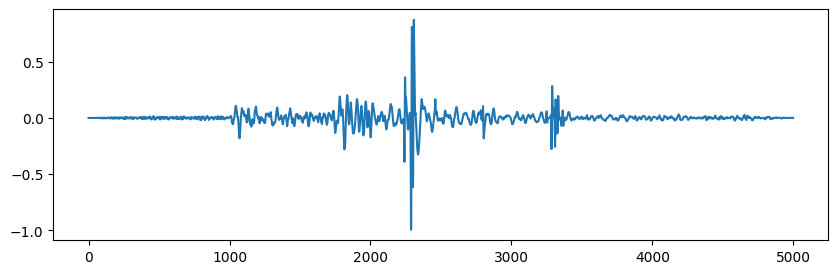

In [37]:
plt.figure(figsize = [10,3])
plt.plot(data[0])


In [ ]:
start_time = 10
end_time = 40
taper_amount = 10
low = 1
high = 15
original_sr = 100
num_corners = 4
new_sr = 100
shift_low = 10
shift_high = 30 
win_len = 100
shifting = True

comcat_file_name = "/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5"
comcat_csv_file = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
f = h5py.File(comcat_file_name, 'r')

buckets = [comcat_csv_file['trace_name'].values[i].split('$')[0] for i in range(len(comcat_csv_file))]
indices = [int(comcat_csv_file['trace_name'].values[i].split('$')[1].split(',')[0]) for i in range(len(comcat_csv_file))]
#p_arrivals = np.array([comcat_csv_file['trace_P_arrival_sample'].values])[0]
source = comcat_csv_file['source_type'].values

buck_exp = np.array(buckets)[np.where(source == 'explosion')[0]]
ind_exp = np.array(indices)[np.where(source == 'explosion')[0]]
#p_arrival_exp = p_arrivals[np.where(source == 'explosion')[0]]


#before = number of samples before p arrival
# Note that the np.full function is defined to create a numpy array of specific shape and fill it with a constant value. 
random_integer_list = np.random.randint(int(shift_low*original_sr), int(shift_high*original_sr), size=len(buck_exp)) if shifting else np.full(len(buck_exp), shift_high)

data_exp = []
for i in tqdm(range(len(buck_exp))):
     data_exp.append(f['/data/'+buck_exp[i]][ind_exp[i], 2, int(5000 - random_integer_list[i]): int(5000 - random_integer_list[i]+ win_len*original_sr)])
               
data_exp = np.array(data_exp)




tapered_exp = apply_cosine_taper(data_exp, taper_percent = taper_amount)  
## Mention the bandpass filter frequencies. 
filtered_exp = np.array(butterworth_filter(data_exp, low, high, original_sr, num_corners, 'bandpass'))

exp_Z = filtered_exp   

# Resampling the data
exp_Z = np.array([resample_array(arr, original_sr, new_sr) for arr in exp_Z])

# Normalizing the data.              
exp_Z = exp_Z/np.max(abs(exp_Z), axis = 1)[:, np.newaxis]



 22%|██▏       | 3450/15943 [00:12<00:49, 251.87it/s]

array([[  7.49481553e-05,   4.88260604e-04,   1.45981488e-03, ...,
          1.13659439e-02,   1.46516625e-02,   1.66006485e-02],
       [  8.44529545e-04,   5.34079688e-03,   1.52278619e-02, ...,
         -1.12613166e-01,  -1.11015287e-01,  -1.25086941e-01],
       [ -1.31868749e-03,  -8.62568167e-03,  -2.59541556e-02, ...,
          1.11017242e-01,   1.00259027e-01,   9.27078051e-02],
       ..., 
       [  2.70429704e-03,   1.75639105e-02,   5.23184296e-02, ...,
          1.73710378e-02,   1.72670383e-02,   1.68645805e-02],
       [ -1.02354843e-02,  -6.72252805e-02,  -2.03598047e-01, ...,
          6.18116658e-03,  -6.72925868e-03,  -1.42343423e-02],
       [ -4.91527872e-04,  -3.49693712e-03,  -1.18206686e-02, ...,
          1.27142517e-02,  -1.25522228e-02,  -4.93321022e-02]])

In [38]:
noise_csv_file = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")

In [42]:
noise_csv_file

,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time
0,noise,UW,BH,TTW,--,47.694,-121.690,542.0,"bucket1$0,:3,:15001",100,2002-09-21T00:50:20.960000Z
1,noise,UW,HH,ERW,--,48.454,-122.626,387.0,"bucket2$0,:3,:15001",100,2002-09-21T00:50:20.960000Z
2,noise,UW,BH,GNW,--,47.564,-122.825,220.0,"bucket3$0,:3,:15001",100,2002-09-21T00:50:20.960000Z
3,noise,UW,BH,OPC,--,48.100,-123.413,90.0,"bucket4$0,:3,:15001",100,2002-09-21T00:50:20.960000Z
4,noise,UW,BH,GNW,--,47.564,-122.825,220.0,"bucket5$0,:3,:15001",100,2002-09-13T14:54:54.050000Z
...,...,...,...,...,...,...,...,...,...,...,...
51457,noise,UW,HH,KTSAP,--,47.518,-122.939,166.9,"bucket1$5122,:3,:15001",100,2022-12-27T10:43:24.810000Z
51458,noise,UW,HH,TKEY,--,47.179,-122.771,47.4,"bucket2$5119,:3,:15001",100,2022-12-27T10:43:24.810000Z
51459,noise,UW,HH,SKOKO,--,47.409,-123.367,949.6,"bucket3$5116,:3,:15001",100,2022-12-27T10:43:24.810000Z
51460,noise,UW,HH,WINDI,--,47.314,-123.332,594.0,"bucket4$5113,:3,:15001",100,2022-12-27T10:43:24.810000Z


In [41]:
noise_csv_file['event_id'].values

KeyError: 'event_id'

In [50]:
random_integer_list

array([1385, 1050, 1582, ..., 2862, 2295, 2504])

In [56]:
for i in range(len(data_exp)):
    if len(data_exp[i]) != 9000:
        print(len(data_exp[i]))
        print(i)

8774
55
8574
154
8902
240
8515
272
8531
335
8866
388
8281
389
8623
419
8675
448
8982
592
8379
1852
8657
1853
8681
2001
8870
2012
8782
2013
7972
2014
8495
2024
8773
2030
8918
2038
8834
2058
8336
2059
8727
2060
8477
2067
8924
2070
8757
2075
8868
2087
7975
2088
8719
2089
8683
2107
8646
2108
8815
2112
8709
2115
8875
2116
8638
2123
8383
2140
7745
2168
8196
2181
8330
2182
7735
2187
8885
2194
8653
2196
7469
2201
8512
2204
8261
2206
8843
2216
8621
2232
8368
2237
8834
2245
8557
2251
8974
2256
8934
2257
8532
2270
7943
2271
8750
2274
8570
2292
8797
2293
8787
2297
8717
2320
8647
2327
8448
2333
8512
2345
8356
2349
8489
2350
7765
2351
8648
2354
8872
2600
8802
2697
8167
2728
8570
2730
8974
2732
8836
2813
8999
2824
8588
2843
8731
2874
8853
2887
8717
2894
8576
3121
8694
3122
8339
3123
8990
3143
8763
3145
8635
3156
8584
3158
8364
3160
8223
3166
8761
3170
8241
3176
8379
3177
8560
3178
8935
3333
8889
3335
8892
3423
8952
3456
8743
3462
8943
3463
8617
3473
8302
3484
8935
3485
8987
3495
8956
3496
8240
3498
8

In [57]:
random_integer_list[55]

1218

In [58]:
p_arrival_exp[55]

7445

In [59]:
7445 - 1218

6227

In [60]:
6227 + 9000

15227